In [17]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [18]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(20, 97, 78)

df = pd.read_csv('s09_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)
centred_moment_5 = moment(org_values, moment=5, axis=1)

centred_moments = np.zeros((78,5))
centred_moments[:,0] = centred_moment_1
centred_moments[:,1] = centred_moment_2
centred_moments[:,2] = centred_moment_3
centred_moments[:,3] = centred_moment_4
centred_moments[:,4] = centred_moment_5

# print(centred_moments.shape)


Add noise to the data (using random sampling from normal distribution)

In [19]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 5
noise_value = 25
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
noise_arr[0] = 1
noise_arr[1] = 10
noise_arr[2] = 100
noise_arr[3] = 5000
noise_arr[4] = 500000


Set-up pints problem and log likelihoods

In [20]:

problem = pints.MultiOutputProblem(model, times, centred_moments)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 7


Create uniform log prior

In [21]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 1
prior_arr_upper[1] = 10000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 10
prior_arr_lower[3] = 0
prior_arr_upper[3] = 2000
prior_arr_lower[4] = 0
prior_arr_upper[4] = 200000
prior_arr_lower[5] = 0
prior_arr_upper[5] = 20000000
prior_arr_lower[6] = 0
prior_arr_upper[6] = 1000000000


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_84979/3441739735.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [22]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 5000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     507     0:01.1
2     1020    0:02.3
3     1518    0:03.3
20    9297    0:20.0
40    18510   0:39.5
60    28443   0:58.2
Halting: Maximum number of iterations (60) reached.
[[[2.70000000e-04 8.10000000e+02 9.00000000e-01 ... 9.00000000e+01
   4.50000000e+03 4.50000000e+05]
  [9.20828035e-05 3.05877176e+02 3.27629747e+00 ... 4.19706420e+03
   1.05964424e+04 8.43539048e+06]
  [1.93727945e-05 2.49241943e+02 3.37356454e+00 ... 4.60494207e+03
   3.42404668e+04 2.10177057e+07]
  ...
  [3.48373206e-05 3.48284990e+02 6.30947076e-14 ... 1.95125951e+04
   3.20030624e+06 3.44804205e+08]
  [3.53650728e-05 3.48960807e+02 5.64848177e-14 ... 2.04843048e+04
   2.95211096e+06 3.35758413e+08]
  [3.54526944e-05 3.49742112e+02 1.34575018e-14 ... 2.09340758e+04
   2.74996815e+06 3.25886194e+08]]

 [[3.15000000e-04 9.45000000e+02 1.05000000e+00 ... 1.05000000e+02
   5.25000000e+03 

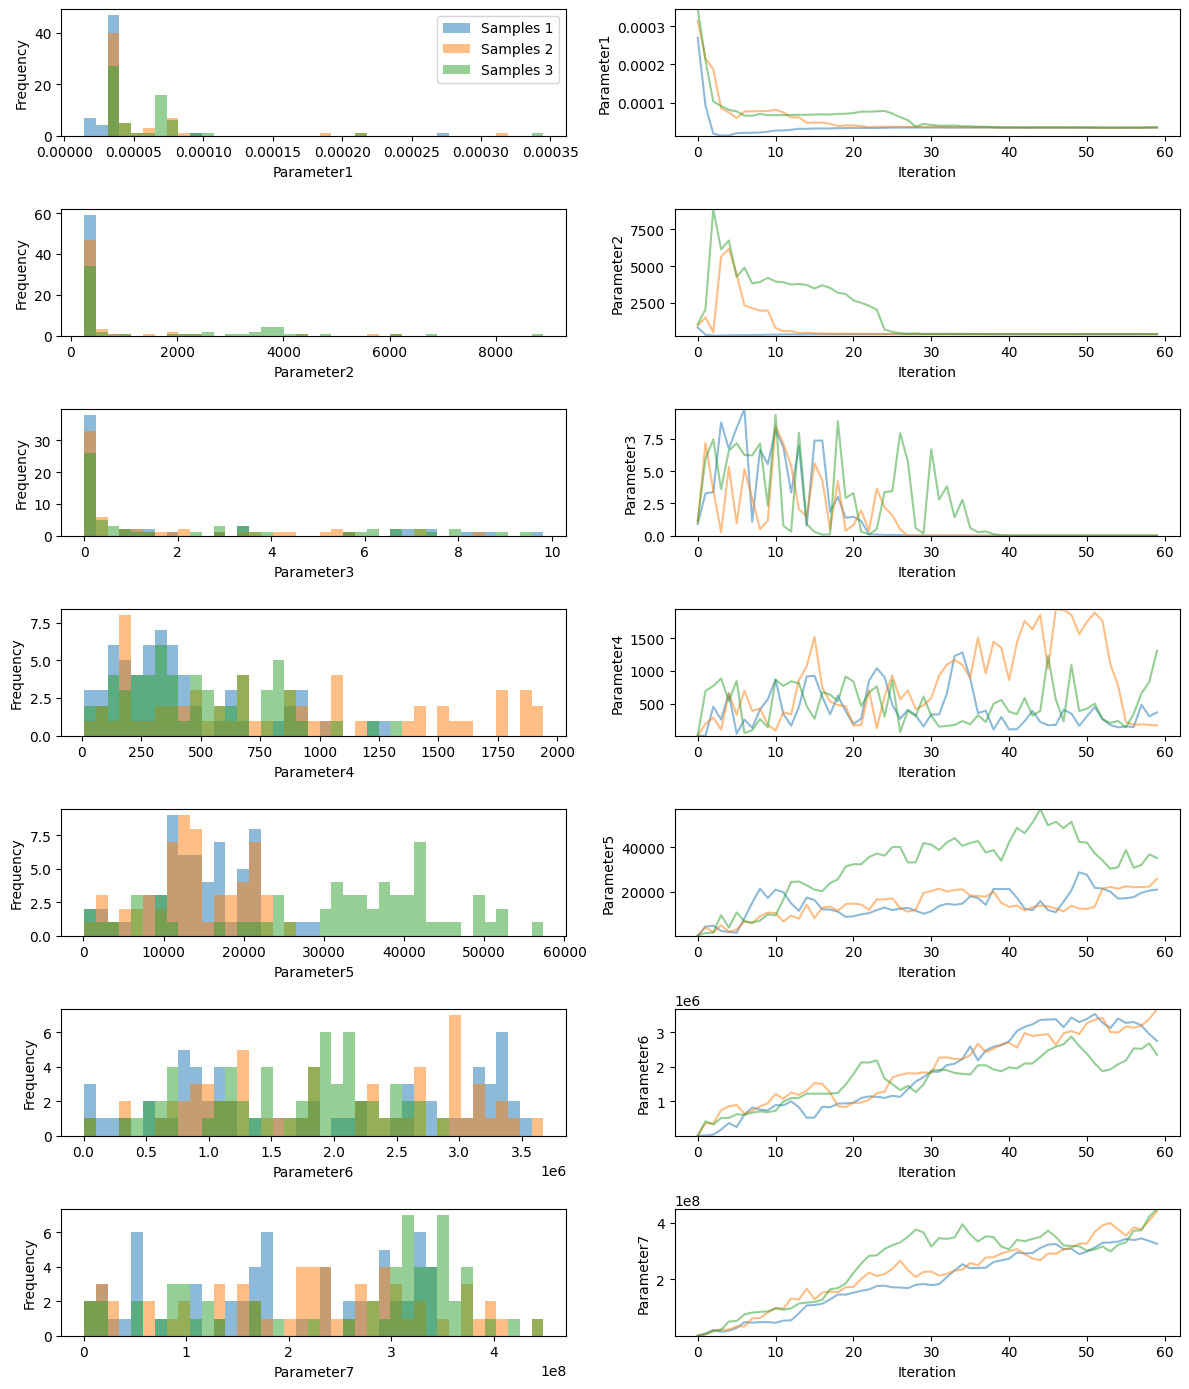

In [32]:

pints.plot.trace(chains)
plt.savefig("mcmc.png")
plt.show()


In [24]:

# ITERS = 100
AllChains = chains[0,:-int(2*ITERS/4),:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(30, 7)
[2.7e-04 8.1e+02 9.0e-01 9.0e+00 9.0e+01 4.5e+03 4.5e+05]
[[2.70000000e-04 8.10000000e+02 9.00000000e-01 9.00000000e+00
  9.00000000e+01 4.50000000e+03 4.50000000e+05]
 [9.20828035e-05 3.05877176e+02 3.27629747e+00 9.44678770e+00
  4.19706420e+03 1.05964424e+04 8.43539048e+06]
 [1.93727945e-05 2.49241943e+02 3.37356454e+00 4.51047564e+02
  4.60494207e+03 3.42404668e+04 2.10177057e+07]
 [1.42488773e-05 2.53455806e+02 8.78054162e+00 2.55470491e+02
  2.26624158e+03 1.81188999e+05 1.43897399e+07]
 [1.48759463e-05 2.68359242e+02 6.73315825e+00 6.55603216e+02
  1.75504459e+03 3.71107961e+05 1.76887227e+07]
 [2.05982633e-05 2.81221850e+02 8.35953453e+00 3.92634385e+01
  1.43313849e+03 2.54507724e+05 2.77061610e+07]
 [2.13324336e-05 2.81165371e+02 9.81816423e+00 2.53602108e+02
  7.91023821e+03 6.20576541e+05 4.83041819e+07]
 [2.16911798e-05 2.83244280e+02 1.08363104e+00 1.28798418e+02
  1.49905170e+04 8.22232055e+05 4.69893447e+07]
 [2.22968930e-05 2.94532963e+02 6.66942167e+00 4.08526

In [25]:

for I in range(3-1):
    AllChains_add = chains[I+1,:-int(2*ITERS/4),:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


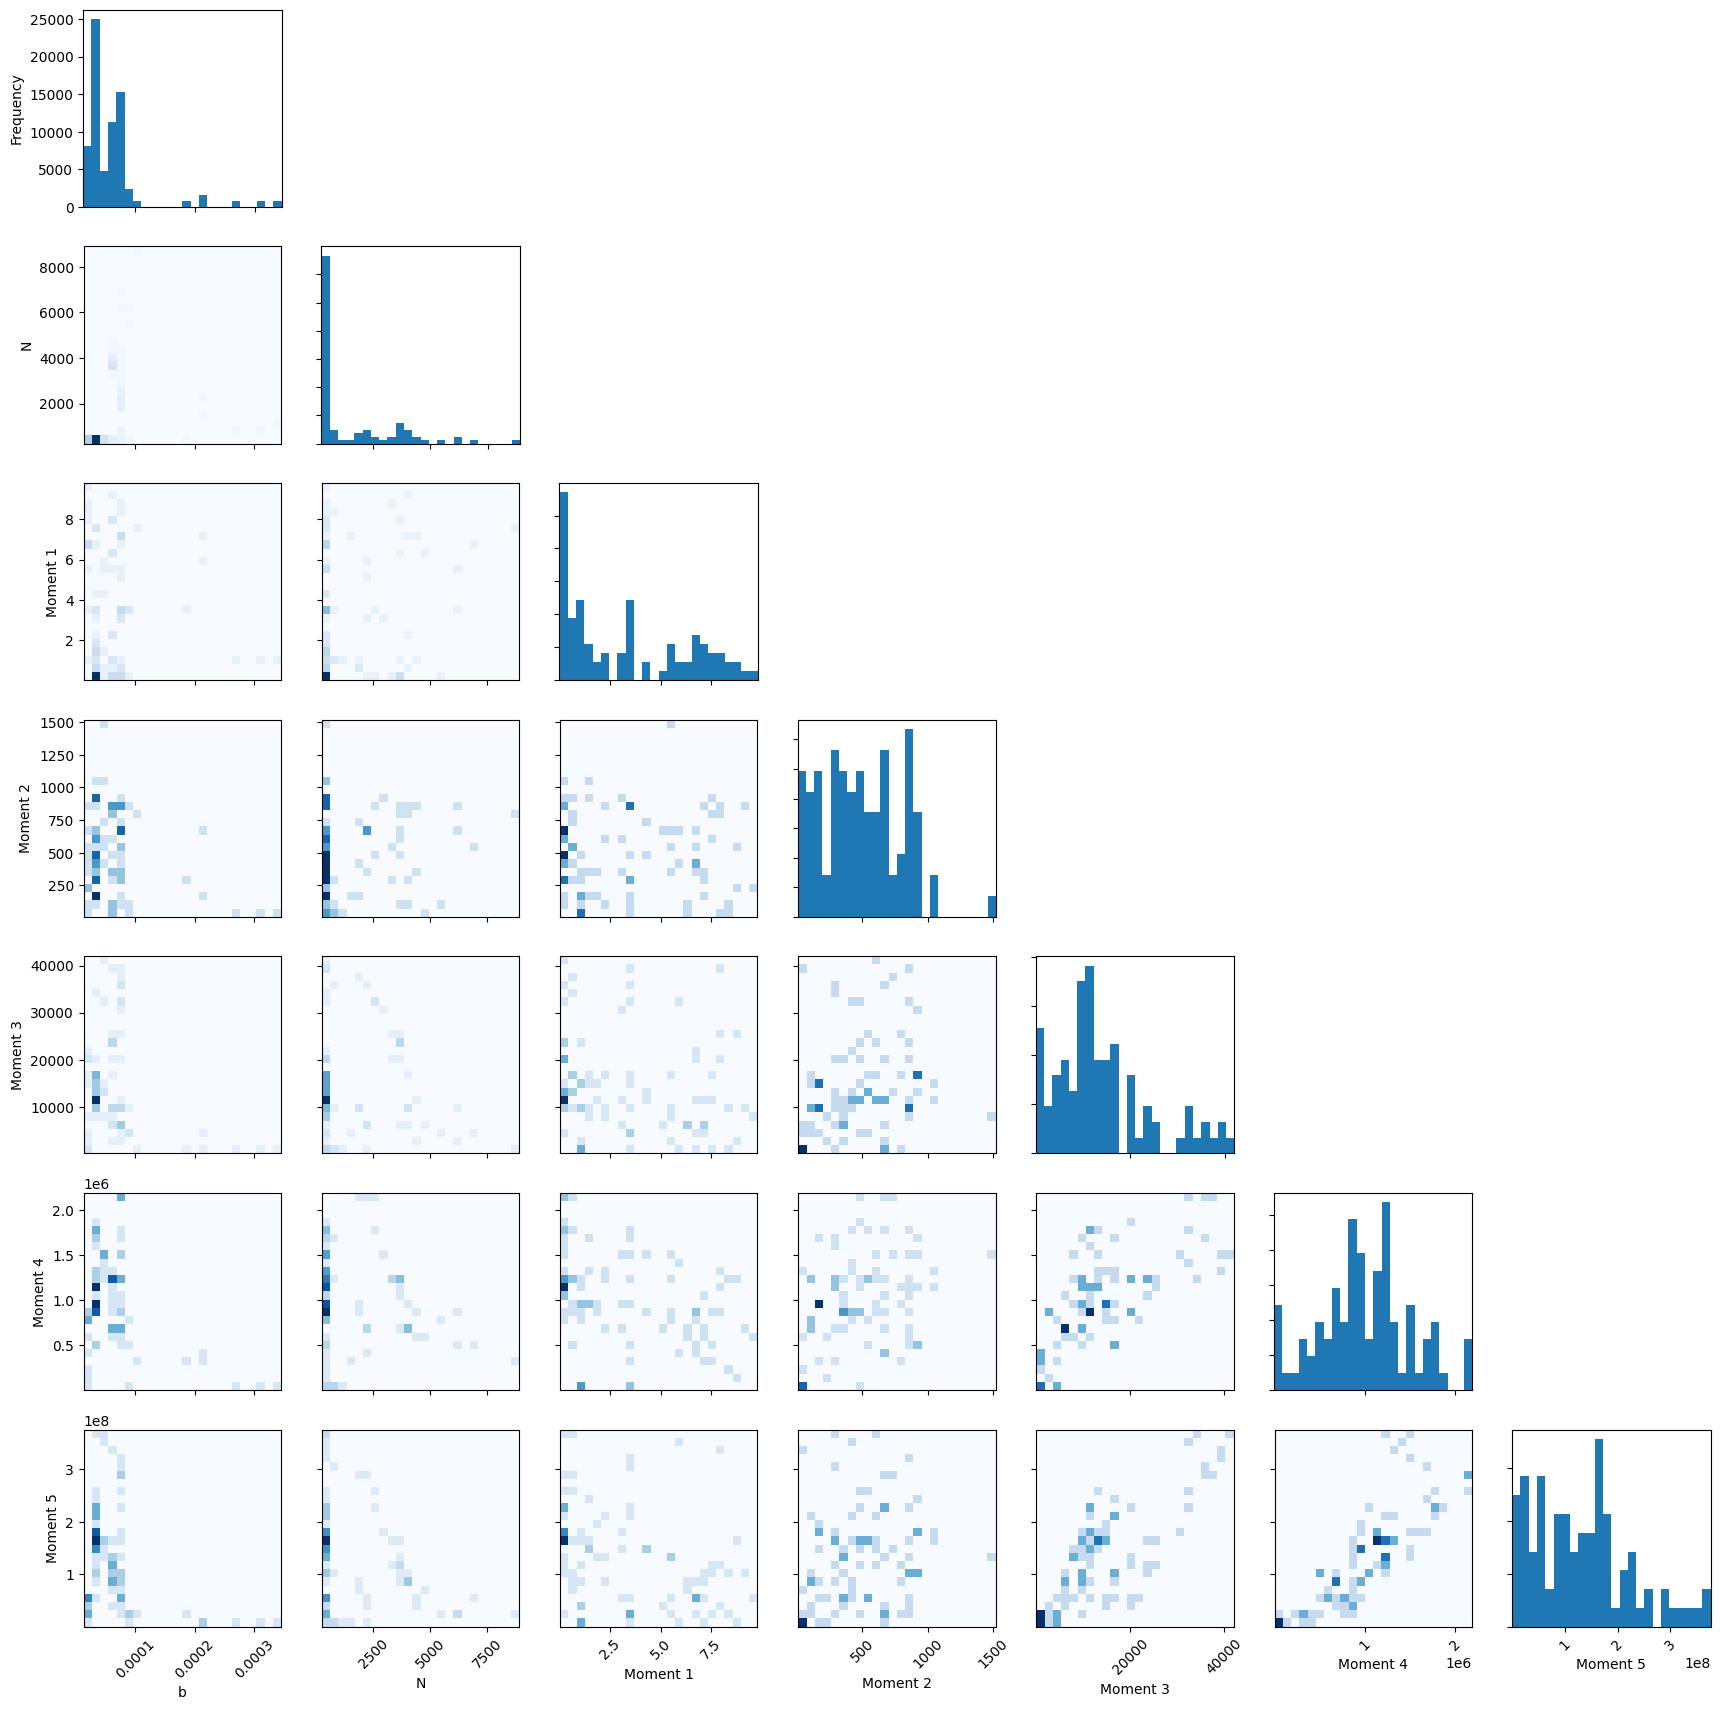

In [26]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"])
plt.show()

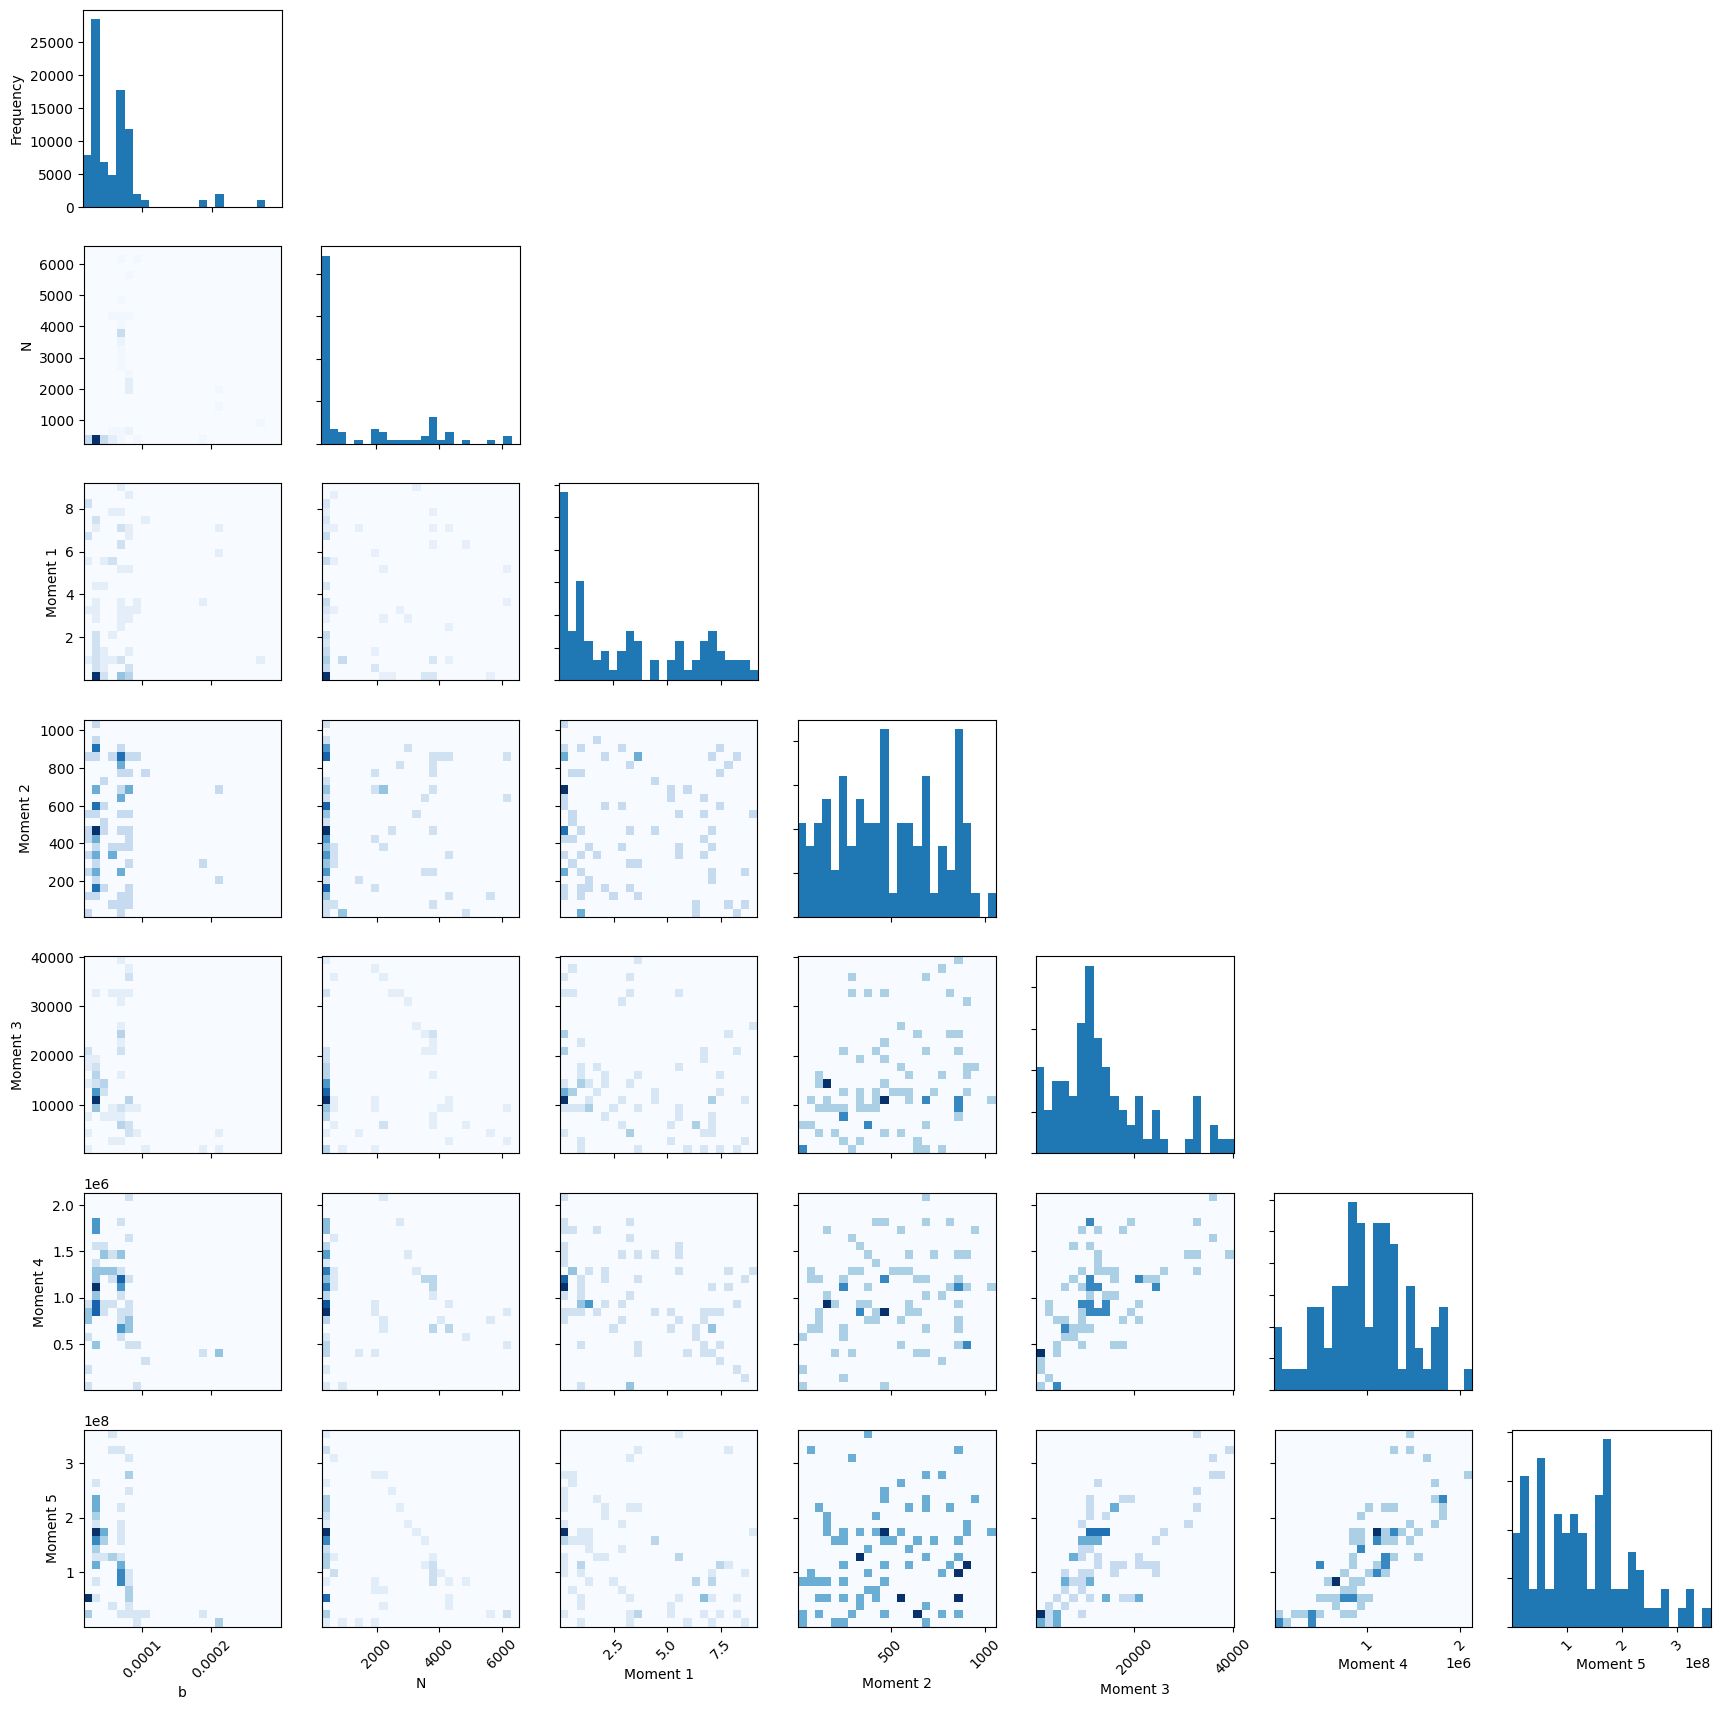

In [27]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"],
                    n_percentiles=97)
plt.show()

[2.7e-04 8.1e+02 9.0e-01 9.0e+00 9.0e+01 4.5e+03 4.5e+05]


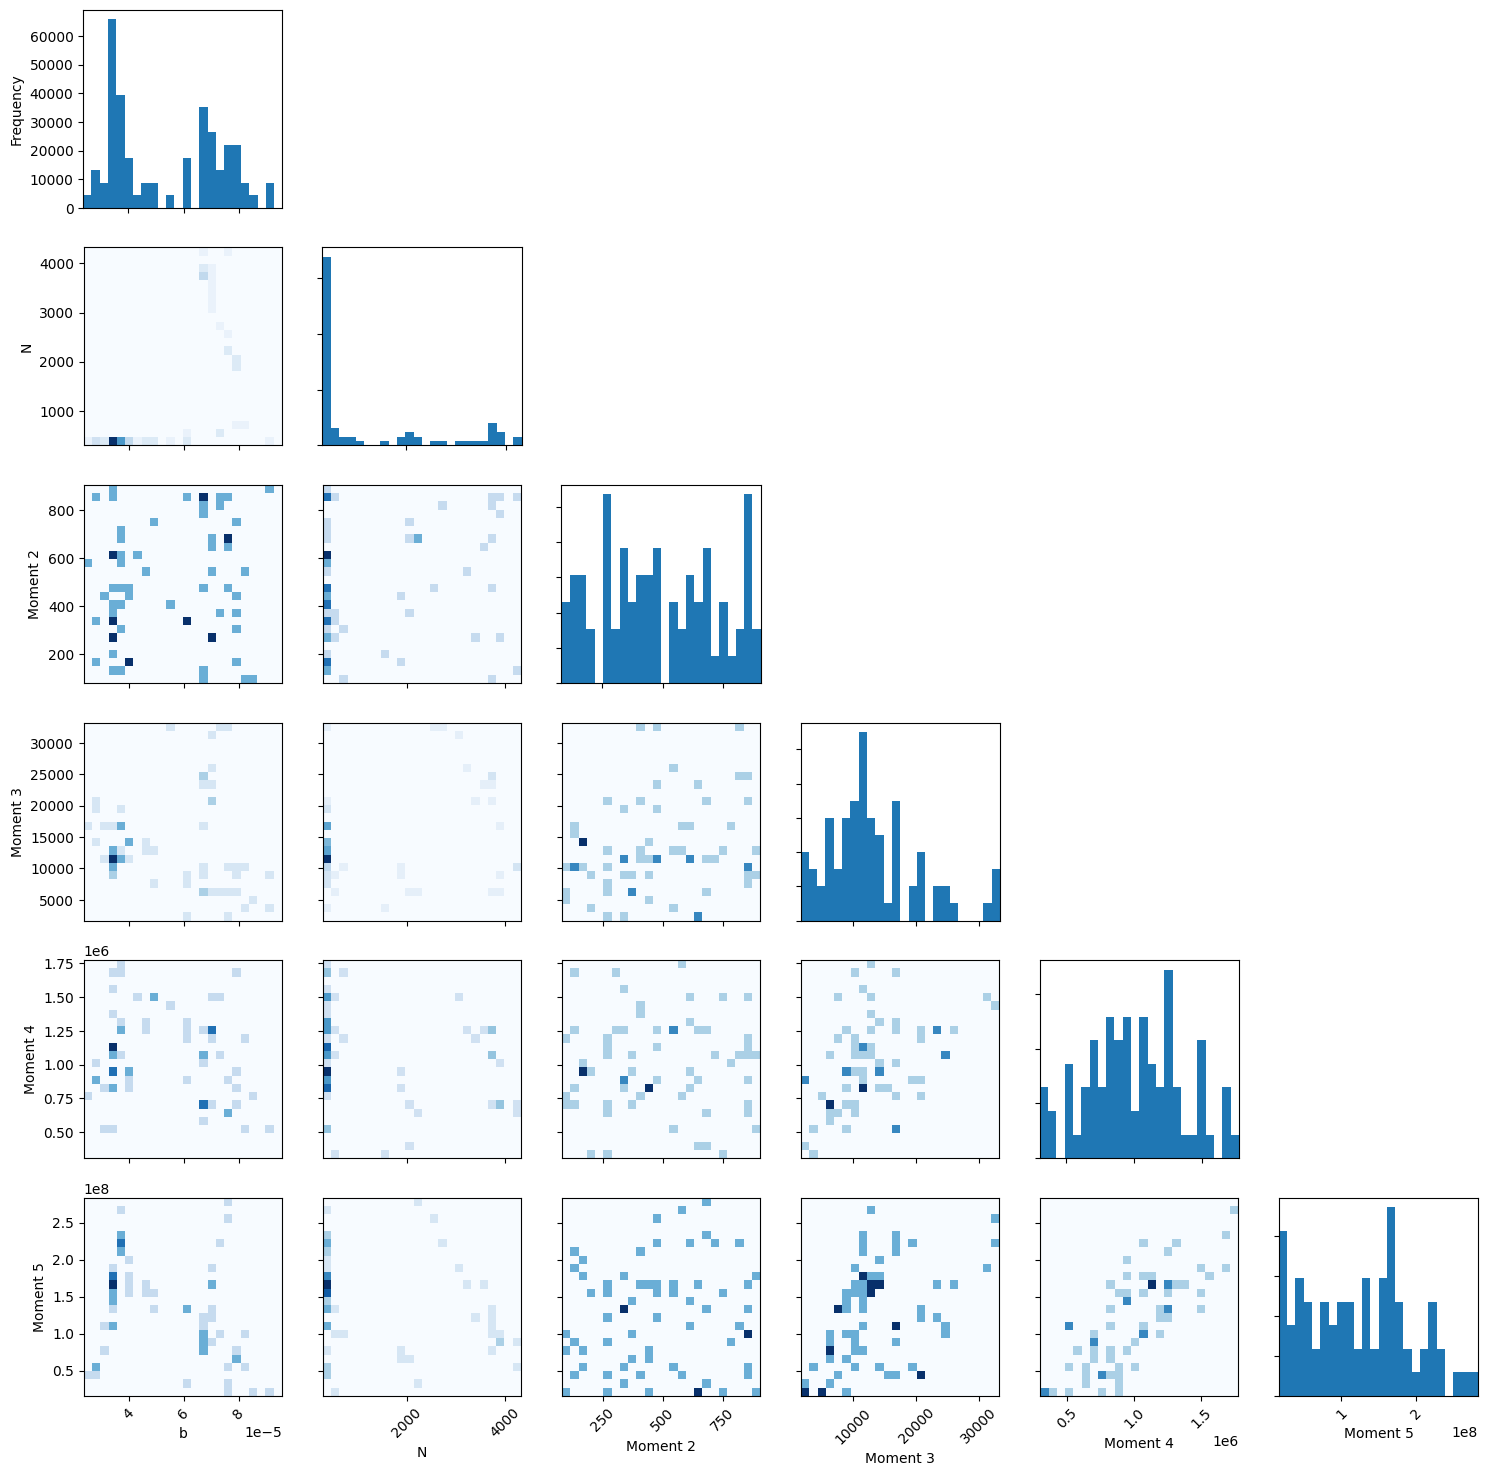

In [28]:
parameter_names = ["b","N", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1,3,4,5,6]], heatmap=True, 
                    parameter_names=["b","N", "Moment 2", "Moment 3", "Moment 4", "Moment 5"],
                    n_percentiles = 85)
plt.show()


In [29]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean          std.         2.5%          25%           50%           75%           97.5%         rhat    ess    ess per sec.
--------  ------------  -----------  ------------  ------------  ------------  ------------  ------------  ------  -----  --------------
b         0.00          0.00         0.00          0.00          0.00          0.00          0.00          1.40    11.14  0.19
N         349.99        5.20         345.45        347.87        348.62        349.50        367.77        1.41    12.42  0.21
Moment 1  0.21          0.90         0.00          0.00          0.00          0.00          2.79          1.16    19.83  0.34
Moment 2  656.86        549.40       112.66        219.97        388.10        1074.82       1880.68       1.38    16.93  0.29
Moment 3  25517.56      12458.28     11232.23      15092.71      21203.88      36496.62      51548.95      2.53    13.60  0.23
Moment 4  2631447.25    533432.58    1820480.04   

In [30]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [31]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  -----  --------------
b         3.56e-05  1.3e-06   3.46e-05  3.5e-05   3.53e-05  3.55e-05  4.01e-05  1.4     11.1   0.192
N         350       5.2       345       348       349       349       368       1.41    12.4   0.214
Moment 1  0.21      0.905     1.19e-16  9.52e-13  7.2e-10   2.26e-06  2.79      1.16    19.8   0.341
Moment 2  657       549       113       220       388       1.07e+03  1.88e+03  1.38    16.9   0.291
Moment 3  2.55e+04  1.25e+04  1.12e+04  1.51e+04  2.12e+04  3.65e+04  5.15e+04  2.53    13.6   0.234
Moment 4  2.63e+06  5.33e+05  1.82e+06  2.12e+06  2.62e+06  3.13e+06  3.43e+06  1.87    10.2   0.175
Moment 5  3.13e+08  5.36e+07  2.09e+08  2.89e+08  3.17e+08  3.44e+08  4.19e+08  1.62    11.5   0.199
